In [2]:
## packages / libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#change scientific numbers to float
np.set_printoptions(formatter={'float_kind' : '{:f}'.format})

sns.set(rc={'figure.figsize':(5,5)})

pd.set_option('display.max_columns', None)

In [3]:
test = pd.read_csv('data/test.csv')
train = pd. read_csv('data/train.csv')
print(f'The shape of the train data is : {train.shape}')
print(f'The shape of the test data is : {test.shape}')

The shape of the train data is : (8693, 14)
The shape of the test data is : (4277, 13)


In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
#check for null values

train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
train_clean = train.copy()
#deal with missing value
# fill missing numerical values with median and categorical values with the mode
strings2 = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin', 'Transported']
numeric2 = ['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for s in strings2:
    mode = train_clean[s].mode()[0]
    train_clean[s] = train_clean[s].fillna(mode)

In [8]:
# change data types

strings = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Transported']
numeric = ['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for s in strings:
    train[s] = train[s].astype((str))

for n in numeric:
    train[n] = train[n].astype(float)

In [9]:
# Explore data
for c in range(len(train_clean.columns)):
    if train_clean.nunique()[c] < 10:
        print(f'The number for values in {train_clean.columns[c]} is {train_clean.nunique()[c]} | {train_clean[train_clean.columns[c]].unique()}')
    else:
        print(f'The number for values in {train_clean.columns[c]} is {train_clean.nunique()[c]}')

The number for values in PassengerId is 8693
The number for values in HomePlanet is 3 | ['Europa' 'Earth' 'Mars']
The number for values in CryoSleep is 2 | [False  True]
The number for values in Cabin is 6560
The number for values in Destination is 3 | ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
The number for values in Age is 80
The number for values in VIP is 2 | [False  True]
The number for values in RoomService is 1273
The number for values in FoodCourt is 1507
The number for values in ShoppingMall is 1115
The number for values in Spa is 1327
The number for values in VRDeck is 1306
The number for values in Name is 8473
The number for values in Transported is 2 | [False  True]


In [10]:
import sys
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows',None)
# train['Cabin'].unique()
# train['Cabin'].value_counts()

In [11]:
train_clean[['Deck','Num','Side']] = train_clean['Cabin'].str.split('/', expand=True)
train_clean = train_clean.drop(columns='Cabin')
train_clean.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


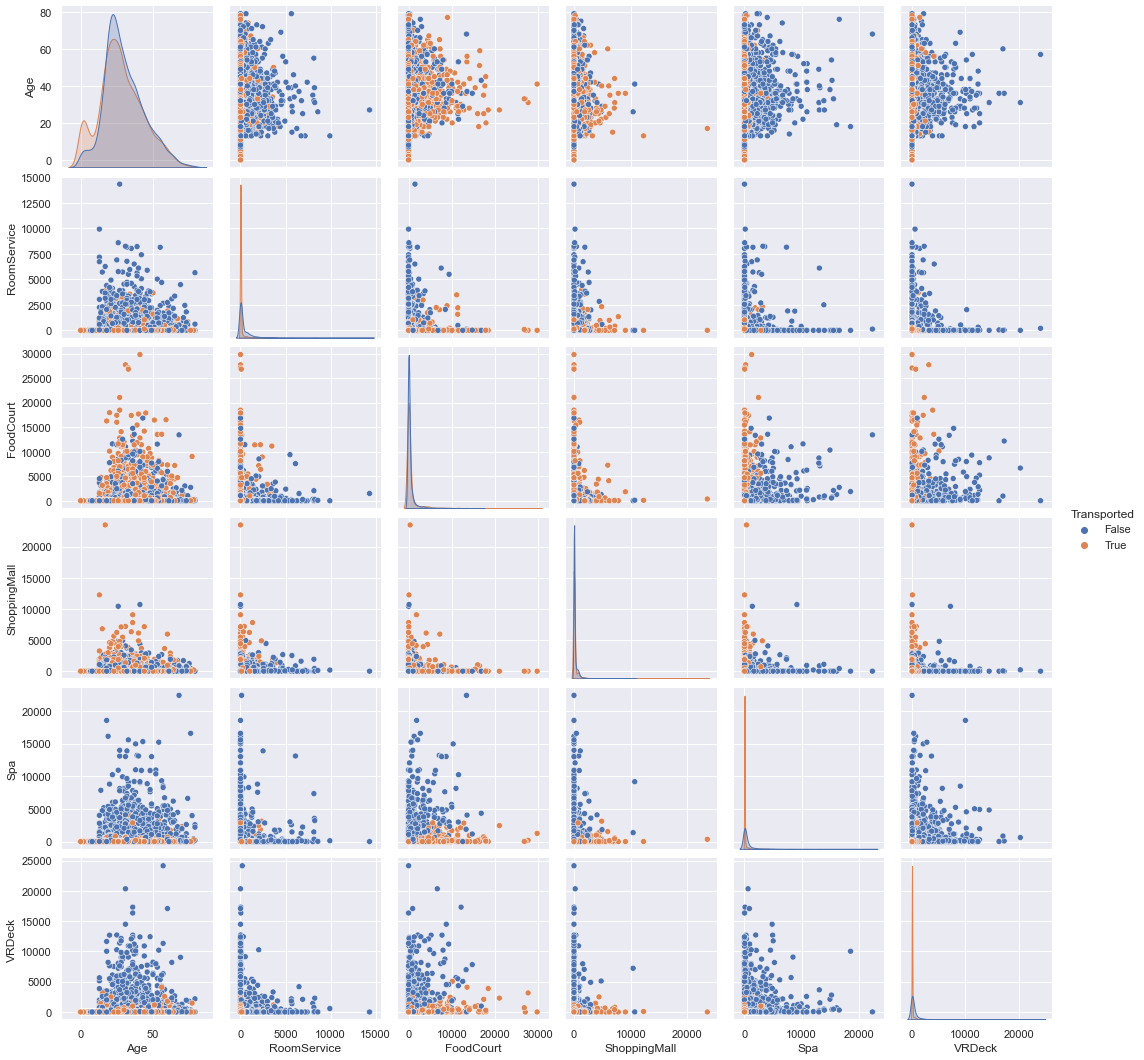

In [12]:
#visualize

g = sns.pairplot(train_clean[['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Transported']], hue ='Transported')

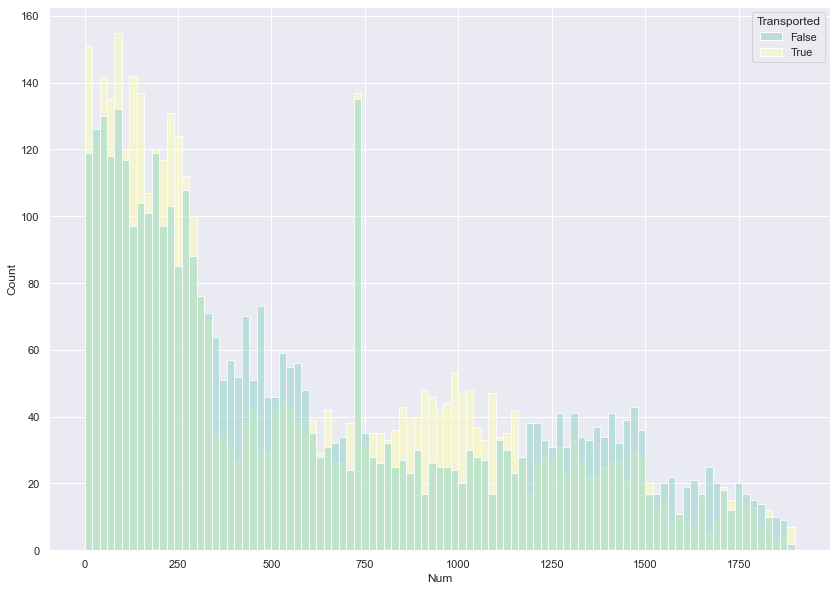

In [13]:
sns.set(rc={'figure.figsize':(14,10)})

num_test = train_clean.copy()
num_test = num_test[~num_test['Num'].isna()]
num_test['Num']= num_test['Num'].astype(int)
ax = sns.histplot(x ='Num', data=num_test, palette='Set3', hue= 'Transported', binwidth=20)

In [14]:
numeric2 = ['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , 'Num']
for n in numeric2:
    median = train_clean[n].median()
    train_clean[n] = train_clean[n].fillna(median)


In [15]:
# feature engineering
train_clean['Num'][train_clean['Num'].isna()] =99999
train_clean['Num'] = train_clean['Num'].astype(int)
train_clean['Cabin_category'] = 'Unknown'
train_clean['Cabin_category'][train_clean['Num'] <= 300] = 'Cabin Category A'
train_clean['Cabin_category'][train_clean['Num'] > 300] = 'Cabin Category B'
train_clean['Cabin_category'][train_clean['Num'] > 600] = 'Cabin Category C'
train_clean['Cabin_category'][train_clean['Num'] > 900] = 'Cabin Category D'
train_clean['Cabin_category'][train_clean['Num'] > 1200] = 'Cabin Category E'
train_clean['Cabin_category'][train_clean['Num'] > 1500] = 'Cabin Category F'
train_clean['Cabin_category'][train_clean['Num'] > 1800] = 'Cabin Category G'

train_clean['Num'][train_clean['Num']==99999] = np.nan
train_clean['Cabin_category'].value_counts()

C:\Users\shane\AppData\Local\Temp/ipykernel_23328/192596041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['Num'][train_clean['Num'].isna()] =99999
C:\Users\shane\AppData\Local\Temp/ipykernel_23328/192596041.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['Cabin_category'][train_clean['Num'] <= 300] = 'Cabin Category A'
C:\Users\shane\AppData\Local\Temp/ipykernel_23328/192596041.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Cabin Category A    3569
Cabin Category B    1484
Cabin Category C    1175
Cabin Category D     991
Cabin Category E     937
Cabin Category F     459
Cabin Category G      78
Name: Cabin_category, dtype: int64

In [16]:
# #deal with missing value
# # fill missing numerical values with median and categorical values with the mode
# strings2 = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin_category', 'Destination', 'VIP', 'Side', 'Deck', 'Transported']
# numeric2 = ['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , 'Num']
#
# for s in strings2:
#     mode = train_clean[s].mode()[0]
#     train_clean[s] = train_clean[s].replace('nan', mode[0])
# for n in numeric2:
#     median = train_clean[n].median()
#     train_clean[n] = train_clean[n].fillna(median)
#
# train_clean['Deck'] = train_clean['Deck'].replace('nan', mode[0])

In [17]:
train_clean[train_clean['Deck'] == 'nan']

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Cabin_category


In [18]:
train_clean.isna().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              200
Transported         0
Deck                0
Num                 0
Side                0
Cabin_category      0
dtype: int64

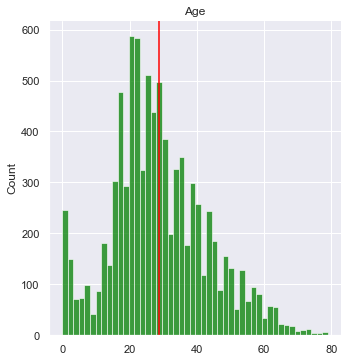

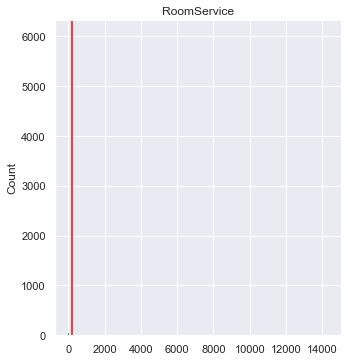

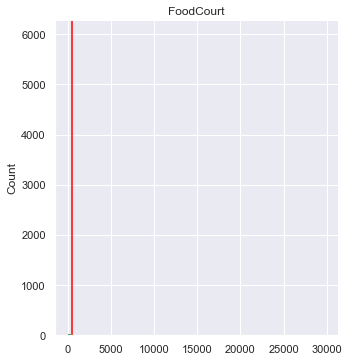

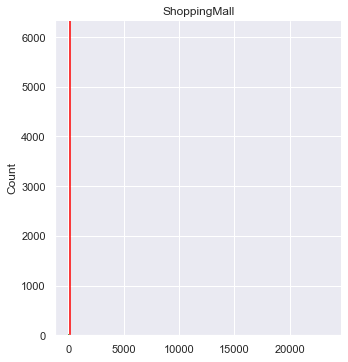

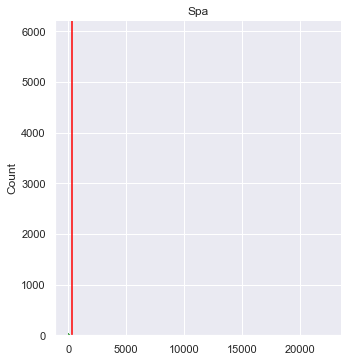

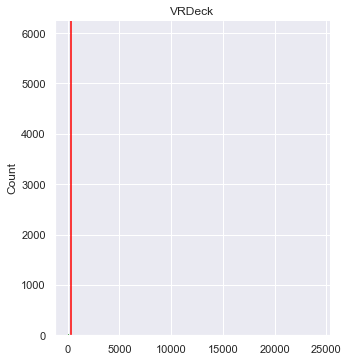

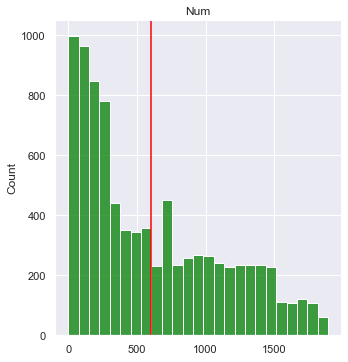

In [19]:
# create distribution plot of numerica valus
for n in numeric2:
    x= train_clean[n].values
    sns.displot(x, color ='green')
    mean = train_clean[n].mean()
    plt.axvline(mean,0,1, color='red')
    plt.title(n)
    plt.show()

Age
The median is : 27.0


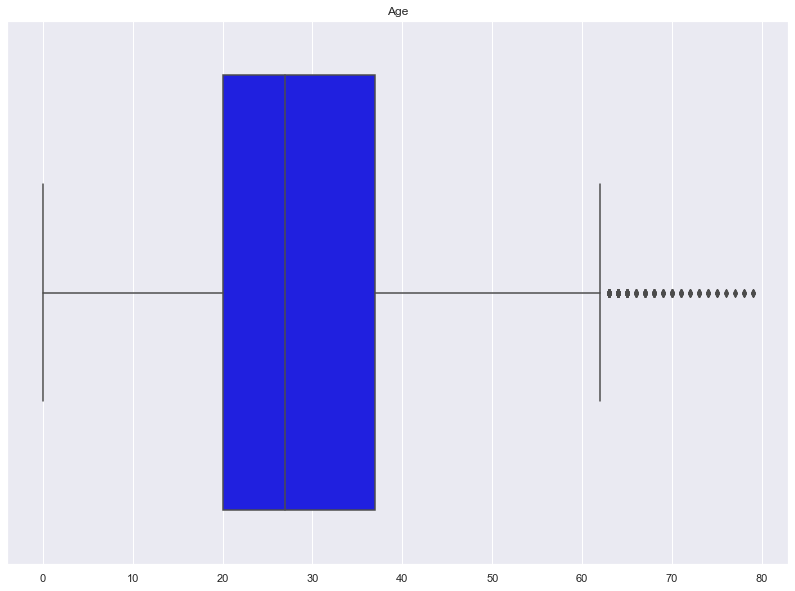

RoomService
The median is : 0.0


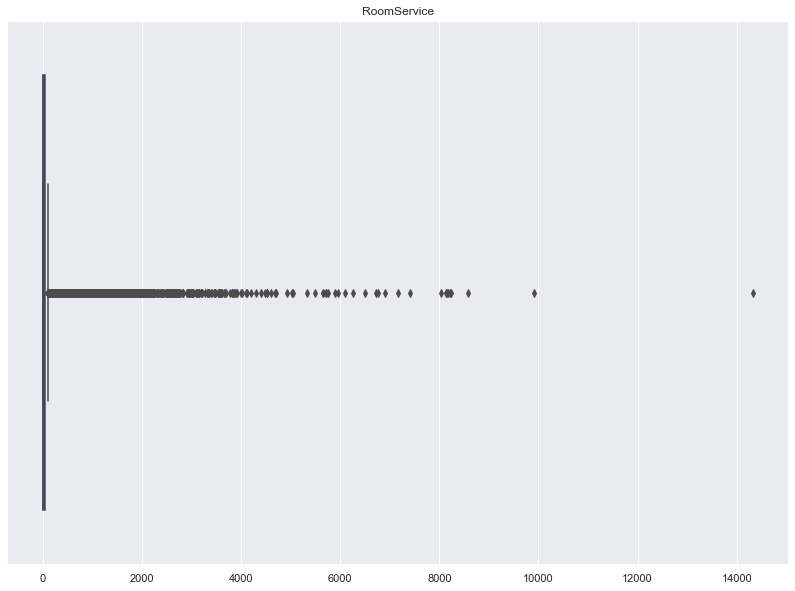

FoodCourt
The median is : 0.0


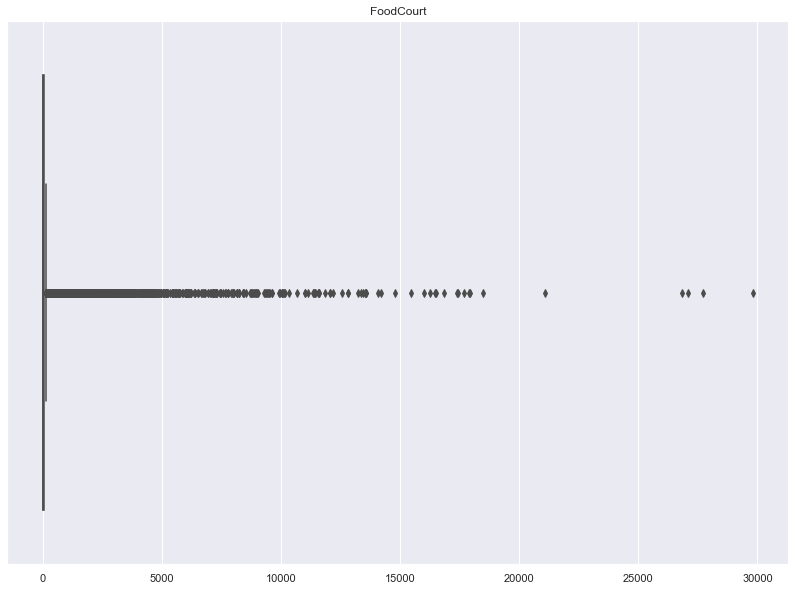

ShoppingMall
The median is : 0.0


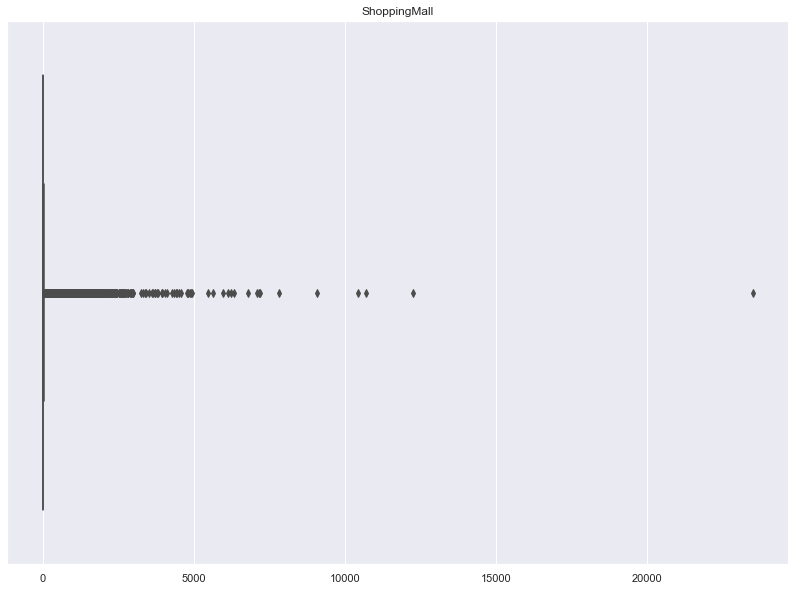

Spa
The median is : 0.0


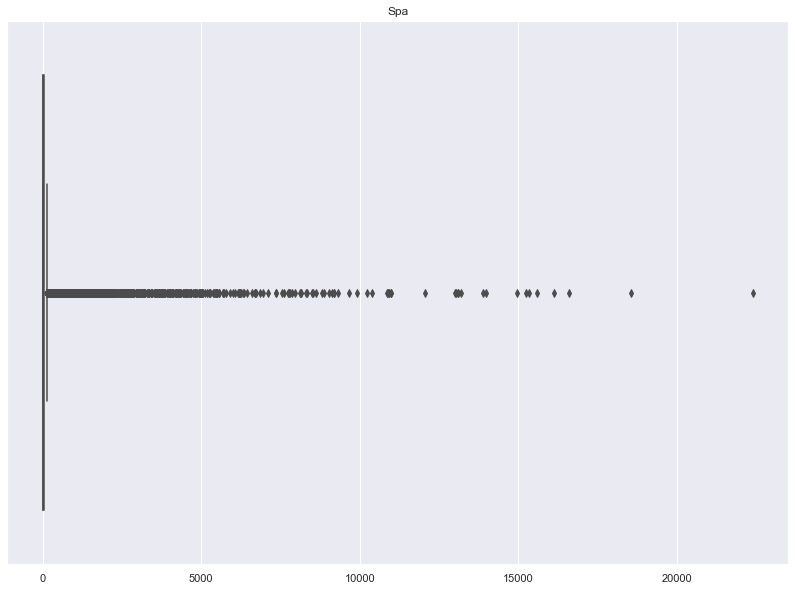

VRDeck
The median is : 0.0


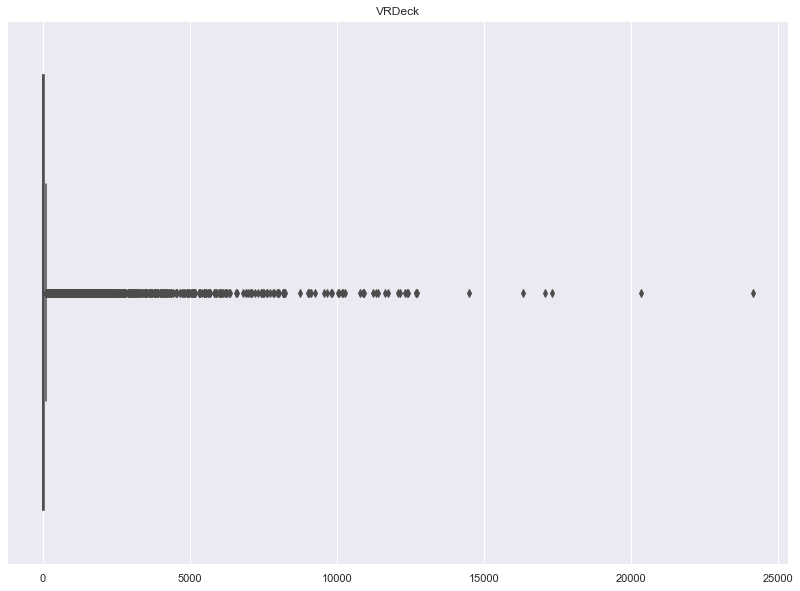

Num
The median is : 448.0


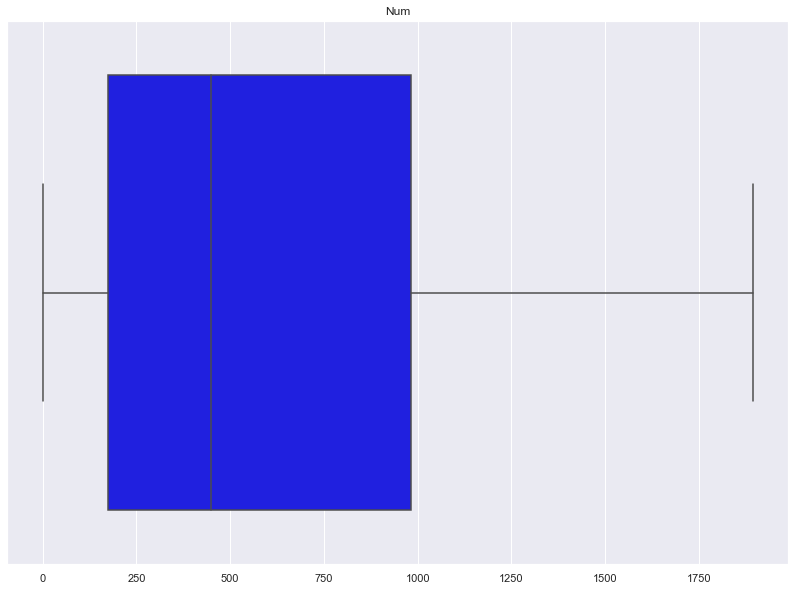

In [20]:
# distributions look skew
#look for outlier with boxplot

for c in numeric2:
    print(c)
    x = train_clean[c].values
    ax = sns.boxplot(x,color='blue')
    print(f'The median is : {train_clean[c].median()}')
    plt.title(c)
    plt.show()

In [21]:
train_clean[train_clean['FoodCourt']> 20000]
train_clean_raw = train_clean.copy()

In [22]:
# foodcourt has outliers but looking at the data we see everyone who spent alot on food got transported
# This is useful for prediction so we won't remove them but we will scale them using log

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_clean[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = scaler.fit_transform(
    train_clean[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
)
train_clean.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Cabin_category
0,0001_01,Europa,False,TRAPPIST-1e,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,B,0,P,Cabin Category A
1,0002_01,Earth,False,TRAPPIST-1e,0.303797,False,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,F,0,S,Cabin Category A
2,0003_01,Europa,False,TRAPPIST-1e,0.734177,True,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,A,0,S,Cabin Category A
3,0003_02,Europa,False,TRAPPIST-1e,0.417722,False,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,A,0,S,Cabin Category A
4,0004_01,Earth,False,TRAPPIST-1e,0.202532,False,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,F,1,S,Cabin Category A


In [24]:
# we need to transform categorical data in to numeric data
train_clean_2 = pd.get_dummies(train_clean,columns=['HomePlanet','CryoSleep','Destination','VIP','Deck','Cabin_category','Side'])
train_clean_2.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Cabin_category_Cabin Category A,Cabin_category_Cabin Category B,Cabin_category_Cabin Category C,Cabin_category_Cabin Category D,Cabin_category_Cabin Category E,Cabin_category_Cabin Category F,Cabin_category_Cabin Category G,Side_P,Side_S
0,0001_01,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0002_01,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
2,0003_01,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0003_02,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0004_01,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [25]:
#feature selection, find which feature are best to use. Correlations and tree based models
train_clean_2.columns

Index(['PassengerId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Name', 'Transported', 'Num', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False',
       'CryoSleep_True', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False',
       'VIP_True', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Cabin_category_Cabin Category A',
       'Cabin_category_Cabin Category B', 'Cabin_category_Cabin Category C',
       'Cabin_category_Cabin Category D', 'Cabin_category_Cabin Category E',
       'Cabin_category_Cabin Category F', 'Cabin_category_Cabin Category G',
       'Side_P', 'Side_S'],
      dtype='object')

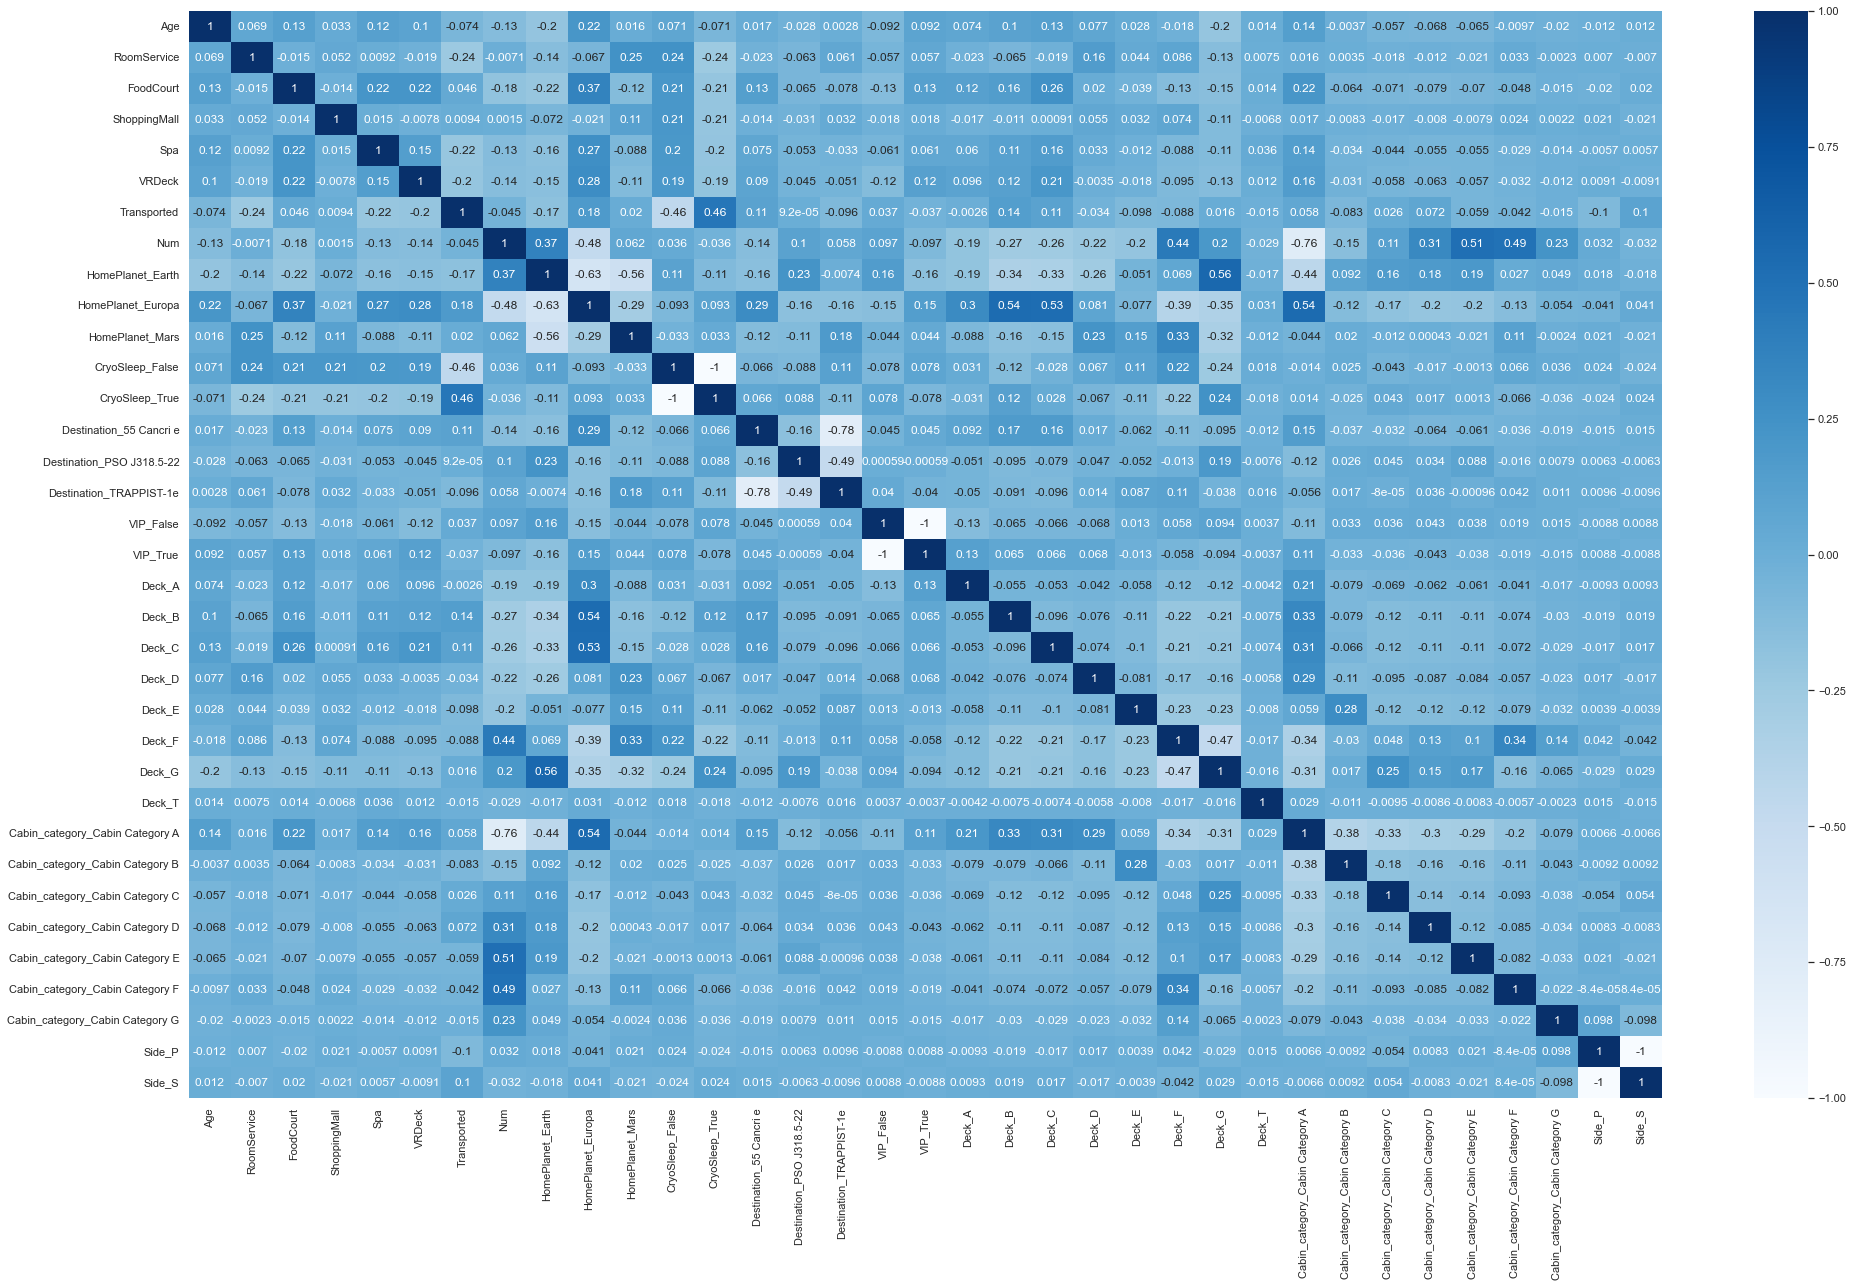

In [26]:
sns.set(rc={'figure.figsize':(33,20)})
corr = train_clean_2.corr(method='pearson')
ax = sns.heatmap(corr,annot=True,cmap='Blues')

In [27]:
from sklearn.tree import DecisionTreeClassifier
X = train_clean_2.drop(['Transported','PassengerId','Name'], axis=1).values
X_cols = train_clean_2.drop(['Transported','PassengerId','Name'], axis=1).columns
y = train_clean_2.Transported.values
train_clean_2.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Cabin_category_Cabin Category A,Cabin_category_Cabin Category B,Cabin_category_Cabin Category C,Cabin_category_Cabin Category D,Cabin_category_Cabin Category E,Cabin_category_Cabin Category F,Cabin_category_Cabin Category G,Side_P,Side_S
0,0001_01,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0002_01,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
2,0003_01,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0003_02,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0004_01,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [28]:
train_clean_2.nunique()

PassengerId                        8693
Age                                  80
RoomService                        1273
FoodCourt                          1507
ShoppingMall                       1115
Spa                                1327
VRDeck                             1306
Name                               8473
Transported                           2
Num                                1817
HomePlanet_Earth                      2
HomePlanet_Europa                     2
HomePlanet_Mars                       2
CryoSleep_False                       2
CryoSleep_True                        2
Destination_55 Cancri e               2
Destination_PSO J318.5-22             2
Destination_TRAPPIST-1e               2
VIP_False                             2
VIP_True                              2
Deck_A                                2
Deck_B                                2
Deck_C                                2
Deck_D                                2
Deck_E                                2


In [29]:
dt = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=10)
dt.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

In [30]:
try:
    del final_fi
except:
    print("")


for i, column in enumerate(train_clean_2.drop(['Transported','PassengerId','Name'], axis=1)):
    print(f'Importance of feature : {column}, {dt.feature_importances_[i]:3f}')
    fi = pd.DataFrame({'Variable':[column], 'Feature Importance Score': [dt.feature_importances_[i]]})

    try:
        final_fi= pd.concat([final_fi,fi], ignore_index=True)
    except:
        final_fi = fi
final_fi = final_fi.sort_values('Feature Importance Score', ascending=False).reset_index()
final_fi


Importance of feature : Age, 0.048211
Importance of feature : RoomService, 0.055743
Importance of feature : FoodCourt, 0.074267
Importance of feature : ShoppingMall, 0.018612
Importance of feature : Spa, 0.102689
Importance of feature : VRDeck, 0.104307
Importance of feature : Num, 0.070742
Importance of feature : HomePlanet_Earth, 0.082035
Importance of feature : HomePlanet_Europa, 0.006996
Importance of feature : HomePlanet_Mars, 0.009118
Importance of feature : CryoSleep_False, 0.304803
Importance of feature : CryoSleep_True, 0.000000
Importance of feature : Destination_55 Cancri e, 0.003439
Importance of feature : Destination_PSO J318.5-22, 0.003529
Importance of feature : Destination_TRAPPIST-1e, 0.006510
Importance of feature : VIP_False, 0.000000
Importance of feature : VIP_True, 0.000000
Importance of feature : Deck_A, 0.002649
Importance of feature : Deck_B, 0.001897
Importance of feature : Deck_C, 0.007584
Importance of feature : Deck_D, 0.000000
Importance of feature : Deck

,index,Variable,Feature Importance Score
0,10,CryoSleep_False,0.304803
1,5,VRDeck,0.104307
2,4,Spa,0.102689
3,7,HomePlanet_Earth,0.082035
4,2,FoodCourt,0.074267
5,6,Num,0.070742
6,1,RoomService,0.055743
7,0,Age,0.048211
8,21,Deck_E,0.039264
9,32,Side_P,0.022705


In [31]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X,y)
y_pred = clf.predict(X)
print('Score:',clf.score(X,y))
pred_prob = clf.predict_proba(X)
logloss = log_loss(y,pred_prob)
print('log loss',logloss)

Score: 0.8046704244794662
log loss 0.4068020812297049


In [32]:
# optimise
X.shape

(8693, 34)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost
classifier = xgboost.XGBClassifier(learning_rate= .002, n_estimators=600, silent=True, ntread=-1 )

params = {
    'learning_rate':[0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth':[2,3,4,5,6,8,10,12,15],
    'min_child_weight':[1,3,5,7,10],
    'gamma':[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'colsample_bytree':[0.3,0.4,0.5,0.7,0.8,0.9,1],
    'subsample':[0.5,0.6,0.8,1]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
clf = RandomizedSearchCV(classifier,param_distributions=params, n_iter=50, scoring='roc_auc', cv=skf.split(X,y), verbose=False, n_jobs=-1)
clf.fit(X,y)
final_model = clf.best_estimator_
final_model.fit(X,y)
print('Score:',final_model.score(X,y))

pred_prob = final_model.predict_proba(X)
logloss = log_loss(y,pred_prob)
print('log loss',logloss)


C:\Users\shane\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "ntread", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:52:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "ntread", "silent" } might not be used.

  This could be a false alarm, with some parameters getti

In [34]:
raw_data = train_clean_raw
raw_data[['probability_yes', 'probability_no']] = pred_prob
raw_data['Model_accuracy'] = final_model.score(X,y)

In [35]:
final_model.score(X,y)

0.842516967675141

In [36]:
test_clean = test.copy()
strings2 = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin']
numeric2 = ['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , 'Num']

for s in strings2:
    mode = test_clean[s].mode()[0]
    test_clean[s] = test_clean[s].fillna(mode)

In [37]:
#clean test data
strings = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
numeric = ['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for s in strings:
    test_clean[s] = test_clean[s].astype((str))

for n in numeric:
    test_clean[n] = test_clean[n].astype(float)

test_clean[['Deck','Num','Side']] = test_clean['Cabin'].str.split('/', expand=True)
test_clean = test_clean.drop(columns='Cabin')
for n in numeric2:
    median = test_clean[n].median()
    test_clean[n] = test_clean[n].fillna(median)

test_clean['Num'][test_clean['Num'].isna()] =99999
test_clean['Num'] = test_clean['Num'].astype(int)
test_clean['Cabin_category'] = 'Unknown'
test_clean['Cabin_category'][test_clean['Num'] <= 300] = 'Cabin Category A'
test_clean['Cabin_category'][test_clean['Num'] > 300] = 'Cabin Category B'
test_clean['Cabin_category'][test_clean['Num'] > 600] = 'Cabin Category C'
test_clean['Cabin_category'][test_clean['Num'] > 900] = 'Cabin Category D'
test_clean['Cabin_category'][test_clean['Num'] > 1200] = 'Cabin Category E'
test_clean['Cabin_category'][test_clean['Num'] > 1500] = 'Cabin Category F'
test_clean['Cabin_category'][test_clean['Num'] > 1800] = 'Cabin Category G'

test_clean['Num'][test_clean['Num']==99999] = np.nan
test_clean['Cabin_category'].value_counts()
test_clean.head()

C:\Users\shane\AppData\Local\Temp/ipykernel_23328/2148340074.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean['Num'][test_clean['Num'].isna()] =99999
C:\Users\shane\AppData\Local\Temp/ipykernel_23328/2148340074.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean['Cabin_category'][test_clean['Num'] <= 300] = 'Cabin Category A'
C:\Users\shane\AppData\Local\Temp/ipykernel_23328/2148340074.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Num,Side,Cabin_category
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S,Cabin Category A
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S,Cabin Category A
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S,Cabin Category A
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S,Cabin Category A
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S,Cabin Category A


In [38]:
test_clean.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Num,Side,Cabin_category
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S,Cabin Category A
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S,Cabin Category A
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S,Cabin Category A
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S,Cabin Category A
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S,Cabin Category A


In [39]:
test_clean[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = scaler.fit_transform(
    test_clean[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
)
test_clean = pd.get_dummies(test_clean,columns=['HomePlanet','CryoSleep','Destination','VIP','Deck','Cabin_category','Side'])

In [40]:
train_clean_2.head()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Num,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Cabin_category_Cabin Category A,Cabin_category_Cabin Category B,Cabin_category_Cabin Category C,Cabin_category_Cabin Category D,Cabin_category_Cabin Category E,Cabin_category_Cabin Category F,Cabin_category_Cabin Category G,Side_P,Side_S
0,0001_01,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0002_01,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
2,0003_01,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0003_02,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0004_01,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [41]:
X_test = X = test_clean.drop(['PassengerId','Name'], axis=1).values

In [42]:
y_pred1 =final_model.predict(X_test)

In [43]:
y_pred1.shape

(4277,)

In [44]:
evaluation_data = pd.read_csv('data/sample_submission.csv')

In [45]:
evaluation_data['Transported'] = y_pred1

In [46]:
#submit to kaggle
submission = evaluation_data
submission.to_csv('data/submission', index=False)

![score](data/score1.jpg)

In [47]:
train_clean.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Cabin_category
0,0001_01,Europa,False,TRAPPIST-1e,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,B,0,P,Cabin Category A
1,0002_01,Earth,False,TRAPPIST-1e,0.303797,False,0.007608,0.000302,0.001064,0.024500,0.001823,Juanna Vines,True,F,0,S,Cabin Category A
2,0003_01,Europa,False,TRAPPIST-1e,0.734177,True,0.003001,0.119948,0.000000,0.299670,0.002030,Altark Susent,False,A,0,S,Cabin Category A
3,0003_02,Europa,False,TRAPPIST-1e,0.417722,False,0.000000,0.043035,0.015793,0.148563,0.007997,Solam Susent,False,A,0,S,Cabin Category A
4,0004_01,Earth,False,TRAPPIST-1e,0.202532,False,0.021149,0.002348,0.006428,0.025214,0.000083,Willy Santantines,True,F,1,S,Cabin Category A


In [48]:
train_clean.to_csv('data/train_clean', index=False)

In [49]:
X.shape, X_test.shape

((4277, 34), (4277, 34))

In [50]:
# pred_prob

In [51]:
raw_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Cabin_category,probability_yes,probability_no,Model_accuracy
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,Cabin Category A,0.324507,0.675493,0.842517
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,Cabin Category A,0.882899,0.117101,0.842517
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,Cabin Category A,0.994268,0.005732,0.842517
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,Cabin Category A,0.996565,0.003435,0.842517
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,Cabin Category A,0.838373,0.161627,0.842517


In [52]:
raw_data.to_csv('data/raw_data', index= False)

In [53]:
raw_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,Cabin_category,probability_yes,probability_no,Model_accuracy
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,Cabin Category A,0.324507,0.675493,0.842517
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,Cabin Category A,0.882899,0.117101,0.842517
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,Cabin Category A,0.994268,0.005732,0.842517
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,Cabin Category A,0.996565,0.003435,0.842517
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,Cabin Category A,0.838373,0.161627,0.842517
